In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [41]:
import json
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
import numpy as np

In [42]:

#reading datasets with pandas
kep = pd.read_csv('kepList.csv')
epic = pd.read_csv('epicList.csv')

In [43]:
kep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2360 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In [44]:
epic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   epic_name       2583 non-null   object 
 1   epic_candname   2583 non-null   object 
 2   pl_name         1022 non-null   object 
 3   k2c_refdisp     2583 non-null   object 
 4   k2c_reflink     2583 non-null   object 
 5   k2c_disp        2583 non-null   object 
 6   k2c_note        76 non-null     object 
 7   k2_campaign     2580 non-null   float64
 8   k2c_recentflag  2583 non-null   int64  
 9   pl_orbper       2560 non-null   float64
 10  pl_orbpererr1   1692 non-null   float64
 11  pl_orbpererr2   1692 non-null   float64
 12  pl_orbperlim    2560 non-null   float64
 13  pl_tranmid      2580 non-null   float64
 14  pl_tranmiderr1  1712 non-null   float64
 15  pl_tranmiderr2  1712 non-null   float64
 16  pl_tranmidlim   2580 non-null   float64
 17  pl_ratdor       1324 non-null   f

In [45]:
#After analyzing the data, I have reduced the columns to features that are present in both datasets

#kepid - epic_name (drop EPIC from name to have unique ID) -> Planet ID for mission
#kepoi_name - epic_candname -> Candidate name
#kepler_name - pl_name -> Planet name
#koi_pdisposition (CANDIDATE/FALSE POSITIVE) - k2c_refdisp (CONFIRMED/CANDIDATE/FALSE POSITIVE) -> Reference disposition (turn into category 1, 0)
#koi_disposition - k2c_disp -> Exoplanet archive disposition (CONFIRMED/CANDIDATE/FALSE POSITIVE) ###THIS IS WHAT WE'RE PREDICTING
#koi_period - pl_orbper -> Oribtal Period (days)
#koi_period_err1 - pl_orbpererr1 -> Oribtal Period Upper Unc. (days)
#koi_period_err2 - pl_orbpererr2 -> Oribtal Period Lower Unc. (days)
#koi_duration - pl_tranmid -> Transit duration(half this)/midpoint  (hrs (convert to days)/days)
#koi_duration_err1 - pl_tranmiderr1 -> Transit duration(half this)/midpoint Upper Unc. (hrs (convert to days)/days)
#koi_duration_err2 - pl_tranmiderr2 -> Transit duration(half this)/midpoint  Lower Unc. (hrs (convert to days)/days)
#koi_prad - pl_rade -> Planet Radius (Earth radii)
#koi_prad_err1 - pl_radeerr1 -> Planet Radius Upper Unc. (Earth radii)
#koi_prad_err2 - pl_radeerr2 -> Planet Radius Lower Unc. (Earth radii)
#koi_srad - st_rad -> Stellar Radius (Solar radii)
#koi_srad_err1 - st_raderr1 -> Stellar Radius Upper Unc. (Solar radii)
#koi_srad_err2 - st_raderr2 -> Stellar Radius Lower Unc. (Solar radii)
#koi_kepmag - st_kep -> Kepler Band (mag)


In [46]:
#drop irrelevant columns

kep = kep[['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_disposition', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'koi_kepmag']]


epic = epic[['epic_name', 'epic_candname', 'pl_name', 'k2c_refdisp', 'k2c_disp', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'st_rad', 'st_raderr1', 'st_raderr2', 'st_kep']]


In [47]:
kep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2360 non-null   object 
 3   koi_pdisposition   9564 non-null   object 
 4   koi_disposition    9564 non-null   object 
 5   koi_period         9564 non-null   float64
 6   koi_period_err1    9110 non-null   float64
 7   koi_period_err2    9110 non-null   float64
 8   koi_duration       9564 non-null   float64
 9   koi_duration_err1  9110 non-null   float64
 10  koi_duration_err2  9110 non-null   float64
 11  koi_prad           9201 non-null   float64
 12  koi_prad_err1      9201 non-null   float64
 13  koi_prad_err2      9201 non-null   float64
 14  koi_srad           9201 non-null   float64
 15  koi_srad_err1      9096 non-null   float64
 16  koi_srad_err2      9096 

In [48]:
epic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   epic_name       2583 non-null   object 
 1   epic_candname   2583 non-null   object 
 2   pl_name         1022 non-null   object 
 3   k2c_refdisp     2583 non-null   object 
 4   k2c_disp        2583 non-null   object 
 5   pl_orbper       2560 non-null   float64
 6   pl_orbpererr1   1692 non-null   float64
 7   pl_orbpererr2   1692 non-null   float64
 8   pl_tranmid      2580 non-null   float64
 9   pl_tranmiderr1  1712 non-null   float64
 10  pl_tranmiderr2  1712 non-null   float64
 11  pl_rade         1913 non-null   float64
 12  pl_radeerr1     1646 non-null   float64
 13  pl_radeerr2     1646 non-null   float64
 14  st_rad          1849 non-null   float64
 15  st_raderr1      1452 non-null   float64
 16  st_raderr2      1452 non-null   float64
 17  st_kep          2580 non-null   f

In [49]:
#Convert columns that need converting, check unique ids

In [50]:
#convert hours to days, duration to midpoint
kep['koi_duration'] = kep['koi_duration']/48
kep['koi_duration_err1'] = kep['koi_duration_err1']/48
kep['koi_duration_err2'] = kep['koi_duration_err2']/48

In [51]:
#rename columns to mutual names and merge

In [52]:
kep['id'] = kep['kepid']
kep.drop('kepid',axis = 'columns',inplace = True) 
epic['id'] = epic['epic_name']
epic.drop('epic_name',axis = 'columns',inplace = True) 

kep['can_name'] = kep['kepoi_name']
kep.drop('kepoi_name',axis = 'columns',inplace = True) 
epic['can_name'] = epic['epic_candname']
epic.drop('epic_candname',axis = 'columns',inplace = True) 

kep['pl_name'] = kep['kepler_name']
kep.drop('kepler_name',axis = 'columns',inplace = True) 

kep['ref_disp'] = kep['koi_pdisposition']
kep.drop('koi_pdisposition',axis = 'columns',inplace = True) 
epic['ref_disp'] = epic['k2c_refdisp']
epic.drop('k2c_refdisp',axis = 'columns',inplace = True) 

kep['disp'] = kep['koi_disposition']
kep.drop('koi_disposition',axis = 'columns',inplace = True) 
epic['disp'] = epic['k2c_disp']
epic.drop('k2c_disp',axis = 'columns',inplace = True) 

kep['pl_orbper'] = kep['koi_period']
kep.drop('koi_period',axis = 'columns',inplace = True) 
kep['pl_orbpererr1'] = kep['koi_period_err1']
kep.drop('koi_period_err1',axis = 'columns',inplace = True) 
kep['pl_orbpererr2'] = kep['koi_period_err2']
kep.drop('koi_period_err2',axis = 'columns',inplace = True) 

kep['pl_tranmid'] = kep['koi_duration']
kep.drop('koi_duration',axis = 'columns',inplace = True) 
kep['pl_tranmiderr1'] = kep['koi_duration_err1']
kep.drop('koi_duration_err1',axis = 'columns',inplace = True) 
kep['pl_tranmiderr2'] = kep['koi_duration_err2']
kep.drop('koi_duration_err2',axis = 'columns',inplace = True) 

kep['pl_rade'] = kep['koi_prad']
kep.drop('koi_prad',axis = 'columns',inplace = True) 
kep['pl_radeerr1'] = kep['koi_prad_err1']
kep.drop('koi_prad_err1',axis = 'columns',inplace = True) 
kep['pl_radeerr2'] = kep['koi_prad_err2']
kep.drop('koi_prad_err2',axis = 'columns',inplace = True) 

kep['st_rad'] = kep['koi_srad']
kep.drop('koi_srad',axis = 'columns',inplace = True) 
kep['st_raderr1'] = kep['koi_srad_err1']
kep.drop('koi_srad_err1',axis = 'columns',inplace = True) 
kep['st_raderr2'] = kep['koi_srad_err2']
kep.drop('koi_srad_err2',axis = 'columns',inplace = True) 

kep['kep_mag'] = kep['koi_kepmag']
kep.drop('koi_kepmag',axis = 'columns',inplace = True) 
epic['kep_mag'] = epic['st_kep']
epic.drop('st_kep',axis = 'columns',inplace = True) 

In [53]:
kep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9564 non-null   int64  
 1   can_name        9564 non-null   object 
 2   pl_name         2360 non-null   object 
 3   ref_disp        9564 non-null   object 
 4   disp            9564 non-null   object 
 5   pl_orbper       9564 non-null   float64
 6   pl_orbpererr1   9110 non-null   float64
 7   pl_orbpererr2   9110 non-null   float64
 8   pl_tranmid      9564 non-null   float64
 9   pl_tranmiderr1  9110 non-null   float64
 10  pl_tranmiderr2  9110 non-null   float64
 11  pl_rade         9201 non-null   float64
 12  pl_radeerr1     9201 non-null   float64
 13  pl_radeerr2     9201 non-null   float64
 14  st_rad          9201 non-null   float64
 15  st_raderr1      9096 non-null   float64
 16  st_raderr2      9096 non-null   float64
 17  kep_mag         9563 non-null   f

In [54]:
epic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_name         1022 non-null   object 
 1   pl_orbper       2560 non-null   float64
 2   pl_orbpererr1   1692 non-null   float64
 3   pl_orbpererr2   1692 non-null   float64
 4   pl_tranmid      2580 non-null   float64
 5   pl_tranmiderr1  1712 non-null   float64
 6   pl_tranmiderr2  1712 non-null   float64
 7   pl_rade         1913 non-null   float64
 8   pl_radeerr1     1646 non-null   float64
 9   pl_radeerr2     1646 non-null   float64
 10  st_rad          1849 non-null   float64
 11  st_raderr1      1452 non-null   float64
 12  st_raderr2      1452 non-null   float64
 13  id              2583 non-null   object 
 14  can_name        2583 non-null   object 
 15  ref_disp        2583 non-null   object 
 16  disp            2583 non-null   object 
 17  kep_mag         2580 non-null   f

In [55]:
#rearrange
epic = epic[['id', 'can_name', 'pl_name', 'ref_disp', 'disp', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'st_rad', 'st_raderr1', 'st_raderr2', 'kep_mag']]

In [56]:
epic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2583 non-null   object 
 1   can_name        2583 non-null   object 
 2   pl_name         1022 non-null   object 
 3   ref_disp        2583 non-null   object 
 4   disp            2583 non-null   object 
 5   pl_orbper       2560 non-null   float64
 6   pl_orbpererr1   1692 non-null   float64
 7   pl_orbpererr2   1692 non-null   float64
 8   pl_tranmid      2580 non-null   float64
 9   pl_tranmiderr1  1712 non-null   float64
 10  pl_tranmiderr2  1712 non-null   float64
 11  pl_rade         1913 non-null   float64
 12  pl_radeerr1     1646 non-null   float64
 13  pl_radeerr2     1646 non-null   float64
 14  st_rad          1849 non-null   float64
 15  st_raderr1      1452 non-null   float64
 16  st_raderr2      1452 non-null   float64
 17  kep_mag         2580 non-null   f

In [57]:
#join the dataframes
import pandas as pd
final_df = pd.concat([kep,epic])

In [58]:
final_df

,id,can_name,pl_name,ref_disp,disp,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag
0,10797460,K00752.01,Kepler-227 b,CANDIDATE,CONFIRMED,9.488036,2.780000e-05,-2.780000e-05,6.161458e-02,0.001706,-0.001706,2.26,0.26,-0.15,0.927,0.105,-0.061,15.347
1,10797460,K00752.02,Kepler-227 c,CANDIDATE,CONFIRMED,54.418383,2.480000e-04,-2.480000e-04,9.389583e-02,0.002417,-0.002417,2.83,0.32,-0.19,0.927,0.105,-0.061,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,19.899140,1.490000e-05,-1.490000e-05,3.712917e-02,0.000710,-0.000710,14.60,3.92,-1.31,0.868,0.233,-0.078,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,1.736952,2.630000e-07,-2.630000e-07,5.013354e-02,0.000112,-0.000112,33.46,8.50,-2.83,0.791,0.201,-0.067,15.597
4,10854555,K00755.01,Kepler-664 b,CANDIDATE,CONFIRMED,2.525592,3.760000e-06,-3.760000e-06,3.446875e-02,0.000875,-0.000875,2.75,0.88,-0.35,1.046,0.334,-0.133,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,EPIC 251394139,EPIC 251394139.01,NaN,FALSE POSITIVE,FALSE POSITIVE,26.286249,NaN,NaN,2.458110e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.763
2579,EPIC 251404897,EPIC 251404897.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.660085,NaN,NaN,2.458096e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.029
2580,EPIC 251411166,EPIC 251411166.01,NaN,FALSE POSITIVE,FALSE POSITIVE,3.374330,NaN,NaN,2.458096e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.179
2581,EPIC 251809286,EPIC 251809286.01,NaN,FALSE POSITIVE,FALSE POSITIVE,9.485826,NaN,NaN,2.458098e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12147 entries, 0 to 2582
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              12147 non-null  object 
 1   can_name        12147 non-null  object 
 2   pl_name         3382 non-null   object 
 3   ref_disp        12147 non-null  object 
 4   disp            12147 non-null  object 
 5   pl_orbper       12124 non-null  float64
 6   pl_orbpererr1   10802 non-null  float64
 7   pl_orbpererr2   10802 non-null  float64
 8   pl_tranmid      12144 non-null  float64
 9   pl_tranmiderr1  10822 non-null  float64
 10  pl_tranmiderr2  10822 non-null  float64
 11  pl_rade         11114 non-null  float64
 12  pl_radeerr1     10847 non-null  float64
 13  pl_radeerr2     10847 non-null  float64
 14  st_rad          11050 non-null  float64
 15  st_raderr1      10548 non-null  float64
 16  st_raderr2      10548 non-null  float64
 17  kep_mag         12143 non-null  

In [60]:
#encode ref_disp categories into columns
df = pd.get_dummies(final_df['ref_disp'], drop_first=True)

final_df = pd.concat([final_df, df],axis = 'columns')

In [61]:
final_df.drop('ref_disp',axis = 'columns',inplace = True) 

In [62]:
final_df.can_name.describe()

count                 12147
unique                11016
top       EPIC 211969807.01
freq                      7
Name: can_name, dtype: object

In [63]:
final_df.id.describe()

count              12147
unique              9510
top       EPIC 201505350
freq                  14
Name: id, dtype: object

In [64]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12147 entries, 0 to 2582
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              12147 non-null  object 
 1   can_name        12147 non-null  object 
 2   pl_name         3382 non-null   object 
 3   disp            12147 non-null  object 
 4   pl_orbper       12124 non-null  float64
 5   pl_orbpererr1   10802 non-null  float64
 6   pl_orbpererr2   10802 non-null  float64
 7   pl_tranmid      12144 non-null  float64
 8   pl_tranmiderr1  10822 non-null  float64
 9   pl_tranmiderr2  10822 non-null  float64
 10  pl_rade         11114 non-null  float64
 11  pl_radeerr1     10847 non-null  float64
 12  pl_radeerr2     10847 non-null  float64
 13  st_rad          11050 non-null  float64
 14  st_raderr1      10548 non-null  float64
 15  st_raderr2      10548 non-null  float64
 16  kep_mag         12143 non-null  float64
 17  CONFIRMED       12147 non-null  

In [65]:
#get obj feature from last two characters in can_name
final_df['obj'] = final_df['can_name'].str.split('\.').str[-1].str.strip()

final_df['obj'] = final_df['obj'].apply(int)

In [66]:
final_df

,id,can_name,pl_name,disp,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,9.488036,2.780000e-05,-2.780000e-05,6.161458e-02,0.001706,-0.001706,2.26,0.26,-0.15,0.927,0.105,-0.061,15.347,0,0,1
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,54.418383,2.480000e-04,-2.480000e-04,9.389583e-02,0.002417,-0.002417,2.83,0.32,-0.19,0.927,0.105,-0.061,15.347,0,0,2
2,10811496,K00753.01,NaN,CANDIDATE,19.899140,1.490000e-05,-1.490000e-05,3.712917e-02,0.000710,-0.000710,14.60,3.92,-1.31,0.868,0.233,-0.078,15.436,0,0,1
3,10848459,K00754.01,NaN,FALSE POSITIVE,1.736952,2.630000e-07,-2.630000e-07,5.013354e-02,0.000112,-0.000112,33.46,8.50,-2.83,0.791,0.201,-0.067,15.597,0,1,1
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,2.525592,3.760000e-06,-3.760000e-06,3.446875e-02,0.000875,-0.000875,2.75,0.88,-0.35,1.046,0.334,-0.133,15.509,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,EPIC 251394139,EPIC 251394139.01,NaN,FALSE POSITIVE,26.286249,NaN,NaN,2.458110e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.763,0,1,1
2579,EPIC 251404897,EPIC 251404897.01,NaN,FALSE POSITIVE,0.660085,NaN,NaN,2.458096e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.029,0,1,1
2580,EPIC 251411166,EPIC 251411166.01,NaN,FALSE POSITIVE,3.374330,NaN,NaN,2.458096e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.179,0,1,1
2581,EPIC 251809286,EPIC 251809286.01,NaN,FALSE POSITIVE,9.485826,NaN,NaN,2.458098e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1


In [67]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12147 entries, 0 to 2582
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              12147 non-null  object 
 1   can_name        12147 non-null  object 
 2   pl_name         3382 non-null   object 
 3   disp            12147 non-null  object 
 4   pl_orbper       12124 non-null  float64
 5   pl_orbpererr1   10802 non-null  float64
 6   pl_orbpererr2   10802 non-null  float64
 7   pl_tranmid      12144 non-null  float64
 8   pl_tranmiderr1  10822 non-null  float64
 9   pl_tranmiderr2  10822 non-null  float64
 10  pl_rade         11114 non-null  float64
 11  pl_radeerr1     10847 non-null  float64
 12  pl_radeerr2     10847 non-null  float64
 13  st_rad          11050 non-null  float64
 14  st_raderr1      10548 non-null  float64
 15  st_raderr2      10548 non-null  float64
 16  kep_mag         12143 non-null  float64
 17  CONFIRMED       12147 non-null  

In [68]:
#forward fill nulls
final_df.fillna(method='ffill',inplace =True)

In [69]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12147 entries, 0 to 2582
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              12147 non-null  object 
 1   can_name        12147 non-null  object 
 2   pl_name         12147 non-null  object 
 3   disp            12147 non-null  object 
 4   pl_orbper       12147 non-null  float64
 5   pl_orbpererr1   12147 non-null  float64
 6   pl_orbpererr2   12147 non-null  float64
 7   pl_tranmid      12147 non-null  float64
 8   pl_tranmiderr1  12147 non-null  float64
 9   pl_tranmiderr2  12147 non-null  float64
 10  pl_rade         12147 non-null  float64
 11  pl_radeerr1     12147 non-null  float64
 12  pl_radeerr2     12147 non-null  float64
 13  st_rad          12147 non-null  float64
 14  st_raderr1      12147 non-null  float64
 15  st_raderr2      12147 non-null  float64
 16  kep_mag         12147 non-null  float64
 17  CONFIRMED       12147 non-null  

In [70]:
#label encode the target variable to classify
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
final_df['disp'] = le.fit_transform(final_df['disp'])

In [71]:
final_df 

#confirmed - 1
#candidate - 0
#false positive - 2

,id,can_name,pl_name,disp,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
0,10797460,K00752.01,Kepler-227 b,1,9.488036,2.780000e-05,-2.780000e-05,6.161458e-02,0.001706,-0.001706,2.26,0.26,-0.15,0.927,0.105,-0.061,15.347,0,0,1
1,10797460,K00752.02,Kepler-227 c,1,54.418383,2.480000e-04,-2.480000e-04,9.389583e-02,0.002417,-0.002417,2.83,0.32,-0.19,0.927,0.105,-0.061,15.347,0,0,2
2,10811496,K00753.01,Kepler-227 c,0,19.899140,1.490000e-05,-1.490000e-05,3.712917e-02,0.000710,-0.000710,14.60,3.92,-1.31,0.868,0.233,-0.078,15.436,0,0,1
3,10848459,K00754.01,Kepler-227 c,2,1.736952,2.630000e-07,-2.630000e-07,5.013354e-02,0.000112,-0.000112,33.46,8.50,-2.83,0.791,0.201,-0.067,15.597,0,1,1
4,10854555,K00755.01,Kepler-664 b,1,2.525592,3.760000e-06,-3.760000e-06,3.446875e-02,0.000875,-0.000875,2.75,0.88,-0.35,1.046,0.334,-0.133,15.509,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,EPIC 251394139,EPIC 251394139.01,HD 80653 b,2,26.286249,2.000000e-02,-1.700000e-03,2.458110e+06,0.003900,-0.004200,4.40,0.12,-0.07,1.760,0.080,-0.080,11.763,0,1,1
2579,EPIC 251404897,EPIC 251404897.01,HD 80653 b,2,0.660085,2.000000e-02,-1.700000e-03,2.458096e+06,0.003900,-0.004200,4.40,0.12,-0.07,1.760,0.080,-0.080,16.029,0,1,1
2580,EPIC 251411166,EPIC 251411166.01,HD 80653 b,2,3.374330,2.000000e-02,-1.700000e-03,2.458096e+06,0.003900,-0.004200,4.40,0.12,-0.07,1.760,0.080,-0.080,14.179,0,1,1
2581,EPIC 251809286,EPIC 251809286.01,HD 80653 b,2,9.485826,2.000000e-02,-1.700000e-03,2.458098e+06,0.003900,-0.004200,4.40,0.12,-0.07,1.760,0.080,-0.080,14.179,0,1,1


In [72]:
final_df.describe()

,disp,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
count,12147.000000,12147.000000,12147.000000,12147.000000,1.214700e+04,12147.000000,12147.000000,12147.000000,12147.000000,12147.000000,12147.000000,12147.000000,12147.000000,12147.000000,12147.000000,12147.00000,12147.000000
mean,1.115831,69.401835,2.988960,-2.097207,5.225117e+05,0.006482,-0.006480,81.179342,14.600519,-26.217959,1.628231,0.325269,-0.363034,14.010072,0.030543,0.41854,1.190747
std,0.842535,1408.893837,287.709929,203.204160,1.005475e+06,0.013231,0.013225,2678.977900,340.683971,1039.466306,5.883727,0.898165,2.210112,1.512015,0.172082,0.49334,0.557204
min,0.000000,0.175660,0.000000,-22320.000000,1.083333e-03,0.000000,-0.420833,0.080000,0.000000,-77200.000000,0.109000,0.000000,-116.137000,5.954000,0.000000,0.00000,1.000000
25%,0.000000,2.688520,0.000009,-0.000570,5.763333e-02,0.001019,-0.006398,1.490000,0.220000,-1.770000,0.800000,0.078000,-0.209000,13.008000,0.000000,0.00000,1.000000
50%,1.000000,8.508333,0.000066,-0.000066,1.011458e-01,0.002771,-0.002771,2.470000,0.470000,-0.320000,0.971000,0.209000,-0.097000,14.179000,0.000000,0.00000,1.000000
75%,2.000000,27.994488,0.000570,-0.000009,3.406458e-01,0.006375,-0.001029,11.500000,1.990000,-0.150000,1.308000,0.341000,-0.058000,15.198000,0.000000,1.00000,1.000000
max,2.000000,129995.778400,31600.000000,0.000000,2.458118e+06,0.420833,0.000000,200346.000000,21600.000000,0.000000,229.908000,33.091000,0.000000,20.003000,1.000000,1.00000,7.000000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)')

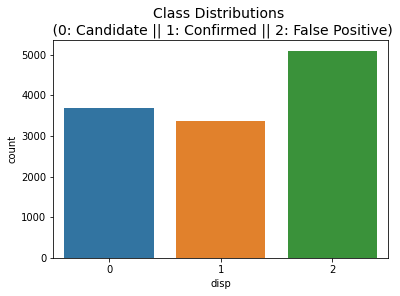

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#check distribution of classes
plt.figure(figsize=(6,4))
colors = ["0", "1", "2"]
sns.countplot('disp', data=final_df)
plt.title('Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)', fontsize=14)

In [74]:
#seperate target and features
X = final_df[['pl_orbper','pl_orbpererr1', 'pl_orbpererr2', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2' ,'pl_rade','pl_radeerr1','pl_radeerr2','st_rad', 'st_raderr1', 'st_raderr2', 'kep_mag', 'CONFIRMED', 'FALSE POSITIVE', 'obj']]
y = final_df[['disp']]

In [75]:
#this does not create equal proportions of classes
#final_train = final_df.iloc[0:11147]
#final_test = final_df.iloc[11147:12148]

#so we use train-test-split

In [76]:
#split train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1)

In [77]:
X_train

,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
6777,578.216230,1.610000e-02,-1.610000e-02,5.639583e-02,0.010563,-0.010563,3.54,1.620,-1.440,3.244,1.486,-1.318,11.619,0,0,1
6709,37.537859,1.280000e-03,-1.280000e-03,1.356875e-01,0.011833,-0.011833,1.77,0.540,-0.230,1.082,0.331,-0.142,15.769,0,0,1
2609,2.941943,1.320000e-05,-1.320000e-05,4.283333e-02,0.002646,-0.002646,1.22,0.100,-0.120,0.758,0.062,-0.075,15.290,0,0,1
2565,11.349445,2.000000e-02,-1.700000e-03,2.458102e+06,0.003900,-0.004200,4.40,0.120,-0.070,0.920,0.010,-0.010,11.636,0,1,1
5253,0.933489,2.510000e-07,-2.510000e-07,2.955500e-02,0.000138,-0.000138,48.01,13.300,-10.900,1.084,0.301,-0.246,16.428,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,14.643071,1.302000e-03,-1.431000e-03,2.457072e+06,0.003038,-0.002793,66.05,43.415,-14.824,13.180,4.640,-2.660,13.124,0,0,1
6385,169.330666,2.480000e-03,-2.480000e-03,5.416667e-02,0.006792,-0.006792,16.68,1.170,-4.280,7.052,0.497,-1.811,13.743,0,0,1
1613,26.866200,5.600000e-03,-5.600000e-03,2.457192e+06,0.002800,-0.003900,3.26,0.160,-0.250,1.290,0.050,-0.030,11.750,0,0,3
3525,44.699656,1.150000e-04,-1.150000e-04,1.297688e-01,0.001479,-0.001479,3.05,0.470,-0.320,1.046,0.161,-0.111,13.967,0,0,1


In [78]:
X_test

,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
1188,1.291510,0.000040,-0.000040,2.457143e+06,0.001000,-0.001000,1.960,0.120,-0.120,0.520,0.070,-0.020,13.905,1,0,1
2276,2.088070,0.000190,-0.000190,2.457302e+06,0.004300,-0.004300,12.400,1.700,-5.800,4.440,0.280,-0.440,14.000,0,0,1
5082,67.451045,0.000086,-0.000086,1.862229e-01,0.001479,-0.001479,36.700,20.800,-25.400,2.191,1.240,-1.515,13.342,0,1,1
9128,0.566803,0.000005,-0.000005,7.385417e-02,0.005271,-0.005271,1.080,0.720,-0.710,1.961,1.297,-1.297,13.945,0,1,1
512,6.429582,0.000290,-0.000307,2.456899e+06,0.002070,-0.002013,2.598,0.331,-0.152,0.820,0.030,-0.030,12.241,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1772,2.226450,0.000140,-0.000140,2.457140e+06,0.003100,-0.002900,2.600,0.190,-0.330,0.780,0.010,-0.020,14.916,0,0,1
5798,2.845740,0.000012,-0.000012,1.516667e-01,0.033333,-0.033333,3.630,0.510,-1.100,2.372,0.331,-0.717,13.591,0,1,1
781,25.276800,0.002600,-0.002600,2.456994e+06,0.004200,-0.004200,25.000,17.000,-17.000,0.520,0.070,-0.070,16.473,0,1,1
1496,46.299105,0.000117,-0.000117,1.093354e-01,0.001271,-0.001271,4.330,1.590,-1.940,1.507,0.553,-0.676,14.082,0,0,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)')

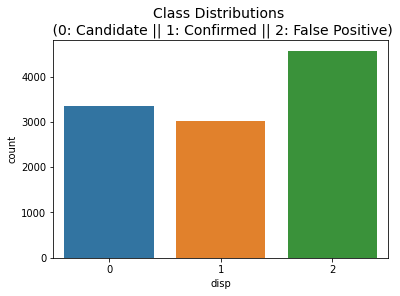

In [79]:
#confirm similar distributions
plt.figure(figsize=(6,4))
colors = ["0", "1", "2"]
sns.countplot('disp', data=y_train)
plt.title('Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)', fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)')

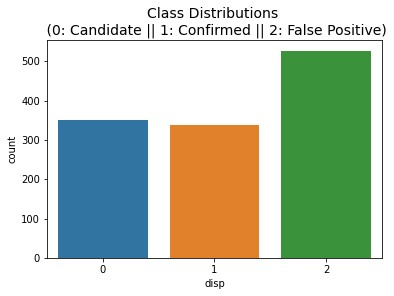

In [80]:
plt.figure(figsize=(6,4))
colors = ["0", "1", "2"]
sns.countplot('disp', data=y_test)
plt.title('Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)', fontsize=14)

In [81]:
#split train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2)

In [82]:
X_train

,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
7907,0.764598,0.000004,-0.000004,2.331250e-02,0.003104,-0.003104,0.720,0.120,-0.160,1.726,0.308,-0.377,11.215,0,1,1
3381,14.485848,0.000025,-0.000025,6.534375e-02,0.001935,-0.001935,2.880,0.450,-0.370,1.085,0.170,-0.139,13.946,0,0,1
5006,36.766236,0.000433,-0.000433,6.885417e-02,0.006854,-0.006854,1.280,0.100,-0.130,0.540,0.044,-0.054,15.903,0,0,1
1572,14.676650,0.000580,-0.000600,2.457153e+06,0.001500,-0.001500,1.940,0.130,-0.250,0.680,0.030,-0.040,12.619,0,0,1
8918,2.411941,0.000018,-0.000018,3.722917e-02,0.006063,-0.006063,1.350,0.210,-0.330,1.594,0.245,-0.398,14.106,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6254,6.702580,0.000043,-0.000043,9.650000e-02,0.004979,-0.004979,403.010,102.000,-102.000,13.652,3.460,-3.460,13.250,0,1,1
8246,8.832419,0.000120,-0.000120,4.691667e-02,0.006854,-0.006854,0.980,0.330,-0.180,1.133,0.376,-0.205,13.303,0,0,1
2167,4.135707,0.000307,-0.000341,2.457302e+06,0.003739,-0.003501,1.600,0.159,-0.108,0.760,0.030,-0.020,12.692,0,0,1
2487,15.871455,0.002113,-0.001670,2.457587e+06,0.004034,-0.004872,2.661,0.464,-0.309,1.210,0.200,-0.130,11.535,1,0,1


In [83]:
X_val

,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
6234,385.292120,0.014800,-0.014800,4.045208e-01,0.012729,-0.012729,1.57,0.52,-0.23,1.053,0.347,-0.156,13.086,0,0,1
8074,0.527679,0.000002,-0.000002,2.906250e-02,0.002437,-0.002437,0.79,0.23,-0.07,0.860,0.242,-0.081,15.356,0,1,1
5841,1.540396,0.000002,-0.000002,3.396875e-02,0.000694,-0.000694,0.94,0.06,-0.04,0.735,0.044,-0.033,12.057,0,1,1
2275,6.981413,0.000076,-0.000076,1.359792e-01,0.006354,-0.006354,1.42,0.09,-0.13,2.163,0.133,-0.193,11.752,0,0,1
3800,367.955660,0.014200,-0.014200,4.557708e-01,0.015250,-0.015250,3.62,0.30,-0.29,0.696,0.056,-0.056,15.964,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,5.409000,0.000040,-0.000040,2.457143e+06,0.001000,-0.001000,1.96,0.12,-0.12,0.520,0.070,-0.020,9.653,0,0,1
4718,13.015183,0.000140,-0.000140,7.527083e-02,0.005708,-0.005708,1.36,0.12,-0.12,0.643,0.057,-0.057,15.961,0,0,1
1764,3.170597,0.000010,-0.000010,3.476250e-02,0.001740,-0.001740,1.69,0.18,-0.06,0.843,0.086,-0.033,15.353,0,0,1
5783,4.174917,0.000131,-0.000131,1.005833e-01,0.013396,-0.013396,0.61,0.25,-0.05,0.940,0.380,-0.081,13.391,0,1,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)')

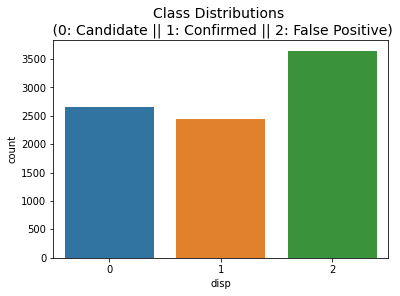

In [84]:
#confirm similar distributions
plt.figure(figsize=(6,4))
colors = ["0", "1", "2"]
sns.countplot('disp', data=y_train)
plt.title('Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)', fontsize=14)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)')

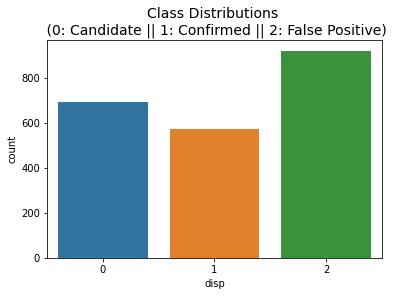

In [85]:
plt.figure(figsize=(6,4))
colors = ["0", "1", "2"]
sns.countplot('disp', data=y_val)
plt.title('Class Distributions \n (0: Candidate || 1: Confirmed || 2: False Positive)', fontsize=14)

In [86]:
from sklearn.model_selection import cross_val_score

SVM

In [87]:
from sklearn import svm

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train.values.ravel())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [88]:
y_pred = clf.predict(X_val)

In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.520     0.356     0.423       691
           1      0.000     0.000     0.000       575
           2      0.509     0.948     0.663       921

    accuracy                          0.512      2187
   macro avg      0.343     0.435     0.362      2187
weighted avg      0.379     0.512     0.413      2187



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


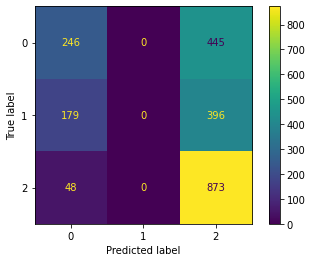

In [90]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val, values_format = '')


Gaussian NB

In [91]:
from sklearn.naive_bayes import GaussianNB

In [92]:
clf = GaussianNB().fit(X_train.values, y_train.values.ravel())

In [93]:
y_pred = clf.predict(X_val)

In [94]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [95]:
print(confusion_matrix(y_val, y_pred))

[[  9 647  35]
 [  0 574   1]
 [  0 815 106]]


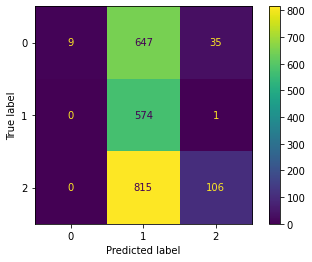

In [96]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val, values_format = '')

In [97]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.013     0.026       691
           1      0.282     0.998     0.440       575
           2      0.746     0.115     0.199       921

    accuracy                          0.315      2187
   macro avg      0.676     0.375     0.222      2187
weighted avg      0.704     0.315     0.208      2187



KNeighbours Classifier

In [98]:
from sklearn.neighbors import KNeighborsClassifier

In [99]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [100]:
y_pred = clf.predict(X_val)

In [101]:
print(confusion_matrix(y_val, y_pred))

[[398 212  81]
 [147 411  17]
 [104  25 792]]


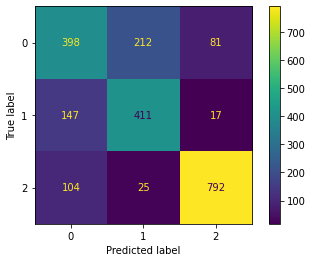

In [102]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

In [103]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.613     0.576     0.594       691
           1      0.634     0.715     0.672       575
           2      0.890     0.860     0.875       921

    accuracy                          0.732      2187
   macro avg      0.712     0.717     0.714      2187
weighted avg      0.735     0.732     0.733      2187



Logistic Regression with Multinomial


In [104]:
y_train_regressor = y_train.values.ravel()

In [105]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class="multinomial").fit(X_train, y_train_regressor)

In [106]:
y_pred = clf.predict(X_val)

In [107]:
print(confusion_matrix(y_val, y_pred))

[[247   0 444]
 [179   0 396]
 [ 51   0 870]]


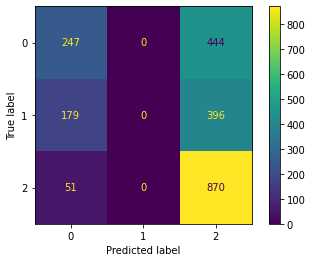

In [108]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

In [109]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.518     0.357     0.423       691
           1      0.000     0.000     0.000       575
           2      0.509     0.945     0.661       921

    accuracy                          0.511      2187
   macro avg      0.342     0.434     0.361      2187
weighted avg      0.378     0.511     0.412      2187



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LogisticRegressionCV with multinomial

In [110]:
from sklearn.linear_model import LogisticRegressionCV

In [111]:
clf = LogisticRegressionCV(multi_class="multinomial", cv=5, random_state=0, max_iter=500).fit(X_train, y_train_regressor)

In [112]:
y_pred = clf.predict(X_val)

In [113]:
print(confusion_matrix(y_val, y_pred))

[[246   0 445]
 [179   0 396]
 [ 48   0 873]]


In [114]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.520     0.356     0.423       691
           1      0.000     0.000     0.000       575
           2      0.509     0.948     0.663       921

    accuracy                          0.512      2187
   macro avg      0.343     0.435     0.362      2187
weighted avg      0.379     0.512     0.413      2187



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


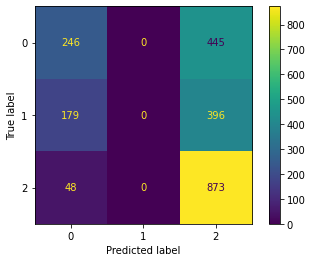

In [115]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

Ridge Classifier

In [116]:
from sklearn.linear_model import RidgeClassifier

In [117]:
clf = RidgeClassifier().fit(X_train, y_train_regressor)

In [118]:
y_pred = clf.predict(X_val)

In [119]:
print(confusion_matrix(y_val, y_pred))

[[596  95   0]
 [340 231   4]
 [  3   1 917]]


In [120]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.635     0.863     0.731       691
           1      0.706     0.402     0.512       575
           2      0.996     0.996     0.996       921

    accuracy                          0.797      2187
   macro avg      0.779     0.753     0.746      2187
weighted avg      0.806     0.797     0.785      2187



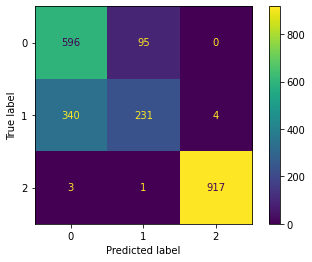

In [121]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

Ridge Classifier CV

In [122]:
from sklearn.linear_model import RidgeClassifierCV

In [123]:
clf = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:1853: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [124]:
y_pred = clf.predict(X_val)

In [125]:
print(confusion_matrix(y_val, y_pred))

[[246   0 445]
 [179   0 396]
 [ 48   0 873]]


In [126]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.520     0.356     0.423       691
           1      0.000     0.000     0.000       575
           2      0.509     0.948     0.663       921

    accuracy                          0.512      2187
   macro avg      0.343     0.435     0.362      2187
weighted avg      0.379     0.512     0.413      2187



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


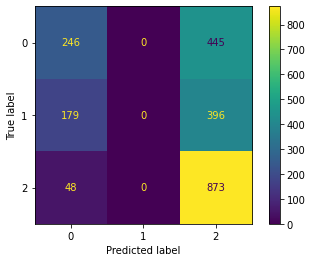

In [127]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

Bernoulli NB

In [128]:
from sklearn.naive_bayes import BernoulliNB

In [129]:
clf = BernoulliNB().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [130]:
y_pred = clf.predict(X_val)

In [131]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [132]:
print(confusion_matrix(y_val, y_pred))

[[686   5   0]
 [500  71   4]
 [  3   1 917]]


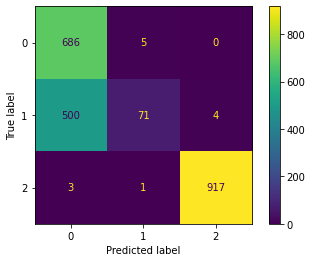

In [133]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val, values_format = '')

In [134]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.577     0.993     0.730       691
           1      0.922     0.123     0.218       575
           2      0.996     0.996     0.996       921

    accuracy                          0.765      2187
   macro avg      0.832     0.704     0.648      2187
weighted avg      0.844     0.765     0.707      2187



Bagging Extra Tree Classifier

In [135]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier

extra_tree = ExtraTreeClassifier(random_state=0)
cls = BaggingClassifier(extra_tree, random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [136]:
y_pred = cls.predict(X_val)

In [137]:
print(confusion_matrix(y_val, y_pred))

[[576 115   0]
 [147 424   4]
 [  2   2 917]]


In [138]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.794     0.834     0.814       691
           1      0.784     0.737     0.760       575
           2      0.996     0.996     0.996       921

    accuracy                          0.877      2187
   macro avg      0.858     0.856     0.856      2187
weighted avg      0.876     0.877     0.876      2187



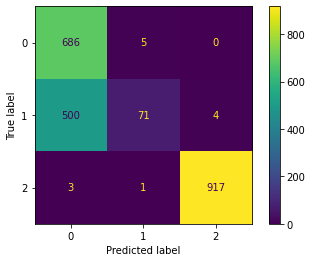

In [139]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val, values_format = '')

DecisionTreeClassifier

In [140]:
from sklearn.tree import DecisionTreeClassifier

In [141]:
clf = DecisionTreeClassifier().fit(X_train, y_train)

In [142]:
y_pred = clf.predict(X_val)

In [143]:
print(confusion_matrix(y_val, y_pred))

[[514 177   0]
 [133 437   5]
 [  1   5 915]]


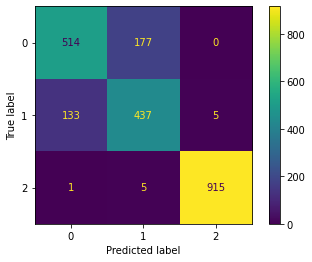

In [145]:
plot_confusion_matrix(clf, X_val, y_val, values_format = '')

In [146]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.793     0.744     0.768       691
           1      0.706     0.760     0.732       575
           2      0.995     0.993     0.994       921

    accuracy                          0.853      2187
   macro avg      0.831     0.832     0.831      2187
weighted avg      0.855     0.853     0.854      2187



XGBoost

In [147]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt

In [149]:
####TEST (WITHOUT PARAMETER TUNING)

#CLF_TEST = XGBClassifier(objective= 'multi:softmax', num_class = 3).fit(X_train,y_train.values.ravel())

#PRD_TEST = CLF_TEST.predict(X_val)

#print(classification_report(y_val, PRD_TEST, digits=3))


              precision    recall  f1-score   support

           0      0.826     0.805     0.815       691
           1      0.769     0.793     0.781       575
           2      0.996     0.996     0.996       921

    accuracy                          0.882      2187
   macro avg      0.864     0.864     0.864      2187
weighted avg      0.883     0.882     0.882      2187



In [159]:
#The following set of code hypertunes the XGBoost parameters

params = {
 'n_estimators':range(50, 400, 50)
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=5,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([1.22253699, 2.46387119, 3.67494602, 4.84262223, 5.98694139,
         7.11221828, 8.23805618]),
  'mean_score_time': array([0.01156058, 0.02574992, 0.04103675, 0.05568366, 0.07039027,
         0.0838943 , 0.09816236]),
  'mean_test_score': array([0.88896512, 0.89536878, 0.89959977, 0.90177244, 0.90268725,
         0.90337336, 0.90360206]),
  'param_n_estimators': masked_array(data=[50, 100, 150, 200, 250, 300, 350],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 50},
   {'n_estimators': 100},
   {'n_estimators': 150},
   {'n_estimators': 200},
   {'n_estimators': 250},
   {'n_estimators': 300},
   {'n_estimators': 350}],
  'rank_test_score': array([7, 6, 5, 4, 3, 2, 1], dtype=int32),
  'split0_test_score': array([0.88965123, 0.89708405, 0.89937107, 0.89994282, 0.90451687,
         0.90165809, 0.90222985]),
  'split1_test_score': array([0.89822756, 0.90165

In [160]:
params = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=5,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=350), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([ 5.49014282,  5.32529817,  5.20030556,  8.20882869,  7.76939425,
          7.50696306, 10.91348438, 10.18220768,  9.84489651, 13.28700476,
         12.24832983, 11.74841104]),
  'mean_score_time': array([0.0706224 , 0.06833172, 0.06597939, 0.09717588, 0.09427762,
         0.09063931, 0.13423128, 0.12311373, 0.11943064, 0.17260966,
         0.1517272 , 0.14504762]),
  'mean_test_score': array([0.89879931, 0.89834191, 0.89879931, 0.90360206, 0.90028588,
         0.90211549, 0.90360206, 0.90097198, 0.90074328, 0.90348771,
         0.90040023, 0.90017153]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
               mask=[False, False, False, False, False, False, False, Fa

In [187]:
params = { 
 'max_depth':[5,8,9],
 'min_child_weight':[0,1,2]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=5,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=350), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([ 9.01717997,  8.03469729,  7.72102952, 14.6488564 , 11.83097968,
         11.36201677, 16.52091913, 12.96607347, 12.32602086]),
  'mean_score_time': array([0.1058938 , 0.09637794, 0.09355688, 0.20556579, 0.15021467,
         0.14027081, 0.2468657 , 0.1705349 , 0.1548861 ]),
  'mean_test_score': array([0.90371641, 0.90360206, 0.90188679, 0.90245855, 0.90417381,
         0.90245855, 0.90394511, 0.90348771, 0.90200114]),
  'param_max_depth': masked_array(data=[5, 5, 5, 8, 8, 8, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[0, 1, 2, 0, 1, 2, 0, 1, 2],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 5, 'min_child_weight': 0},
   {'max_depth': 5, 'min_child_weig

In [162]:
params = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=350), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([12.15294952, 12.2458497 , 12.38778219, 12.42145176, 12.44640355]),
  'mean_score_time': array([0.15273199, 0.14294329, 0.13123541, 0.12401953, 0.11609817]),
  'mean_test_score': array([0.90417381, 0.90314465, 0.90165809, 0.90200114, 0.90371641]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([1, 3, 5, 4, 2], dtype=int32),
  'split0_test_score': array([0.8976558 , 0.8976558 , 0.89422527, 0.89937107, 0.89937107]),
  'split1_test_score': array([0.91252144, 0.90737564, 0.9079474 , 0.90851915, 0.91538022]),
  'split2_test_score': array([0.90222985, 0.90108634, 0.9028016 , 0.89822756, 0.89879931]),
  'split3_test_score': array([0.90737564, 0.90680389, 0.90337336, 0.90451687, 0.90680389]),
  'split4_test_score':

In [163]:
params = {
 'n_estimators':range(50, 400, 50)
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([ 1.89849215,  3.70795207,  5.51625509,  7.26598353,  8.92809854,
         10.6107131 , 12.20872092]),
  'mean_score_time': array([0.01757674, 0.03685942, 0.0575201 , 0.07871199, 0.10170546,
         0.12762871, 0.15309219]),
  'mean_test_score': array([0.8974271 , 0.90383076, 0.90474557, 0.90360206, 0.90531732,
         0.90440252, 0.90417381]),
  'param_n_estimators': masked_array(data=[50, 100, 150, 200, 250, 300, 350],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 50},
   {'n_estimators': 100},
   {'n_estimators': 150},
   {'n_estimators': 200},
   {'n_estimators': 250},
   {'n_estimators': 300},
   {'n_estimators': 350}],
  'rank_test_score': array([7, 5, 2, 6, 1, 3, 4], dtype=int32),
  'split0_test_score': array([0.89422527, 0.89651229, 0.89994282, 0.89708405, 0.89879931,
         0.89822756, 0.8976558 ]),
  'split1_test_score': array([0.91080617, 

In [164]:
params = {  
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([7.70042429, 7.70080447, 7.58690567, 7.39978957, 8.61223569,
         8.60661936, 8.4996964 , 8.29381137, 9.08125067, 9.13172054,
         9.00787835, 8.83575482, 9.97813654, 9.99735084, 9.83690639,
         9.59424267]),
  'mean_score_time': array([0.10835509, 0.10683894, 0.10531807, 0.1048214 , 0.10479178,
         0.10570412, 0.10394087, 0.10127683, 0.10389771, 0.10467372,
         0.10273566, 0.09985852, 0.10226679, 0.10038161, 0.09873128,
         0.09646921]),
  'mean_test_score': array([0.90211549, 0.9025729 , 0.90200114, 0.90383076, 0.90188679,
         0.90485992, 0.90463122, 0.90337336, 0.90245855, 0.90371641,
         0.90531732, 0.90337336, 0.90211549, 0.9023442 , 0.90291595,
         0.90337336]),
  'param_colsample_bytree': masked_array(data=[0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8,
                     0.8, 0.9, 0.9, 0.9, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False, F

In [165]:
params = { 
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([8.93305779, 8.97781906, 9.04144878, 9.00265837, 9.08563161]),
  'mean_score_time': array([0.10094895, 0.10087113, 0.10179548, 0.10092416, 0.10102558]),
  'mean_test_score': array([0.90531732, 0.90337336, 0.90348771, 0.90440252, 0.90154374]),
  'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0},
   {'reg_alpha': 0.001},
   {'reg_alpha': 0.005},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.05}],
  'rank_test_score': array([1, 4, 3, 2, 5], dtype=int32),
  'split0_test_score': array([0.89879931, 0.89822756, 0.89937107, 0.89536878, 0.89594054]),
  'split1_test_score': array([0.91423671, 0.91080617, 0.90966266, 0.91080617, 0.9079474 ]),
  'split2_test_score': array([0.90165809, 0.90222985, 0.89994282, 0.90451687, 0.90165809]),
  'split3_test_score': array([0.9079474 , 0.9028016 , 0.90680389, 0.90851915, 0.9022298

In [167]:
params = { 
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([9.35158539, 8.84790316, 8.79231353, 8.93413606, 9.6789536 ]),
  'mean_score_time': array([0.11288304, 0.10208483, 0.10038495, 0.10155773, 0.10441852]),
  'mean_test_score': array([0.90394511, 0.90337336, 0.90405946, 0.90531732, 0.89994282]),
  'param_reg_lambda': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lambda': 1e-05},
   {'reg_lambda': 0.01},
   {'reg_lambda': 0.1},
   {'reg_lambda': 1},
   {'reg_lambda': 100}],
  'rank_test_score': array([3, 4, 2, 1, 5], dtype=int32),
  'split0_test_score': array([0.90222985, 0.89708405, 0.90108634, 0.89879931, 0.89594054]),
  'split1_test_score': array([0.90623213, 0.90337336, 0.90909091, 0.91423671, 0.90680389]),
  'split2_test_score': array([0.90508862, 0.90451687, 0.89879931, 0.90165809, 0.89822756]),
  'split3_test_score': array([0.90680389, 0.90680389, 0.90737564, 0.9079474 , 0.9073756

In [168]:
param_s = { 
 'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([8.28001065, 9.02372532, 8.91887307, 8.88265934, 8.79320426]),
  'mean_score_time': array([0.09691443, 0.10707936, 0.10334554, 0.10343952, 0.10187368]),
  'mean_test_score': array([0.9030303 , 0.90451687, 0.90348771, 0.90337336, 0.90451687]),
  'param_reg_lambda': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_lambda': 0},
   {'reg_lambda': 0.001},
   {'reg_lambda': 0.005},
   {'reg_lambda': 0.01},
   {'reg_lambda': 0.05}],
  'rank_test_score': array([5, 1, 3, 4, 1], dtype=int32),
  'split0_test_score': array([0.90108634, 0.89822756, 0.89422527, 0.89708405, 0.90165809]),
  'split1_test_score': array([0.90737564, 0.91137793, 0.91080617, 0.90337336, 0.91194969]),
  'split2_test_score': array([0.89937107, 0.90337336, 0.90165809, 0.90451687, 0.90108634]),
  'split3_test_score': array([0.9079474 , 0.90566038, 0.9079474 , 0.90680389, 0.9

In [169]:
params = {
 'n_estimators':range(50, 400, 50)
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250, reg_lambda = 1), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([ 1.88638825,  3.72103686,  5.49338136,  7.2540504 ,  8.9314703 ,
         10.51915779, 12.10499415]),
  'mean_score_time': array([0.01765242, 0.03697934, 0.05844502, 0.07896833, 0.10218062,
         0.12732573, 0.15323586]),
  'mean_test_score': array([0.8974271 , 0.90383076, 0.90474557, 0.90360206, 0.90531732,
         0.90440252, 0.90417381]),
  'param_n_estimators': masked_array(data=[50, 100, 150, 200, 250, 300, 350],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 50},
   {'n_estimators': 100},
   {'n_estimators': 150},
   {'n_estimators': 200},
   {'n_estimators': 250},
   {'n_estimators': 300},
   {'n_estimators': 350}],
  'rank_test_score': array([7, 5, 2, 6, 1, 3, 4], dtype=int32),
  'split0_test_score': array([0.89422527, 0.89651229, 0.89994282, 0.89708405, 0.89879931,
         0.89822756, 0.8976558 ]),
  'split1_test_score': array([0.91080617, 

In [170]:
params = {
 'learning_rate':[1e-5, 1e-2, 0.1, 1, 100]
}
gs = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250, reg_lambda = 1), 
 param_grid = params, cv=5)
gs.fit(X_train,y_train.values.ravel())
gs.cv_results_, gs.best_params_, gs.best_score_

({'mean_fit_time': array([8.96755161, 9.15745053, 8.87843204, 5.82790909, 1.51887436]),
  'mean_score_time': array([0.07925434, 0.08226342, 0.10059557, 0.06925611, 0.00841036]),
  'mean_test_score': array([0.88393368, 0.89445397, 0.90531732, 0.89605489, 0.32246998]),
  'param_learning_rate': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'learning_rate': 1e-05},
   {'learning_rate': 0.01},
   {'learning_rate': 0.1},
   {'learning_rate': 1},
   {'learning_rate': 100}],
  'rank_test_score': array([4, 3, 1, 2, 5], dtype=int32),
  'split0_test_score': array([0.87993139, 0.89193825, 0.89879931, 0.89365352, 0.30188679]),
  'split1_test_score': array([0.89365352, 0.90566038, 0.91423671, 0.90051458, 0.28016009]),
  'split2_test_score': array([0.87878788, 0.89079474, 0.90165809, 0.90165809, 0.27958834]),
  'split3_test_score': array([0.88736421, 0.89651229, 0.9079474 , 0.8

In [171]:
gpredict = gs.predict(X_val)

In [172]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
gcm = confusion_matrix(y_val, gpredict)

In [173]:
print(gcm)

[[575 116   0]
 [ 90 481   4]
 [  2   2 917]]


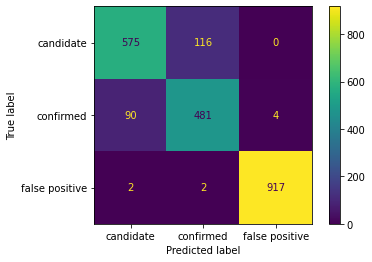

In [179]:
plot_confusion_matrix(gs, X_val, y_val, values_format = '', display_labels=['candidate', 'confirmed', 'false positive'])

In [180]:
print(classification_report(y_val, gpredict, digits=3))

              precision    recall  f1-score   support

           0      0.862     0.832     0.847       691
           1      0.803     0.837     0.819       575
           2      0.996     0.996     0.996       921

    accuracy                          0.902      2187
   macro avg      0.887     0.888     0.887      2187
weighted avg      0.903     0.902     0.902      2187



In [181]:
y_pred_final = gs.predict(X_test)

cm = confusion_matrix(y_test, y_pred_final)
print(cm)

[[297  53   0]
 [ 56 282   0]
 [  1   2 524]]


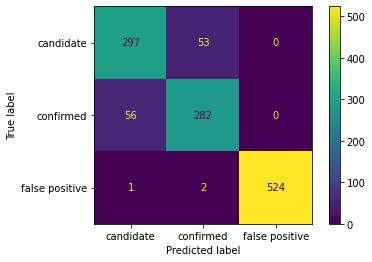

In [183]:
plot_confusion_matrix(gs, X_test, y_test, values_format = '', display_labels=['candidate', 'confirmed', 'false positive'])

In [184]:
print(classification_report(y_test, y_pred_final, digits=3))

              precision    recall  f1-score   support

           0      0.839     0.849     0.844       350
           1      0.837     0.834     0.836       338
           2      1.000     0.994     0.997       527

    accuracy                          0.908      1215
   macro avg      0.892     0.892     0.892      1215
weighted avg      0.908     0.908     0.908      1215



[0]	validation_0-merror:0.104517	validation_1-merror:0.125103
[1]	validation_0-merror:0.094454	validation_1-merror:0.121811
[2]	validation_0-merror:0.094454	validation_1-merror:0.116872


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3]	validation_0-merror:0.092739	validation_1-merror:0.116049
[4]	validation_0-merror:0.092624	validation_1-merror:0.115226
[5]	validation_0-merror:0.094568	validation_1-merror:0.118519
[6]	validation_0-merror:0.087364	validation_1-merror:0.114403
[7]	validation_0-merror:0.08462	validation_1-merror:0.118519
[8]	validation_0-merror:0.084048	validation_1-merror:0.115226
[9]	validation_0-merror:0.082561	validation_1-merror:0.11358
[10]	validation_0-merror:0.082104	validation_1-merror:0.117695
[11]	validation_0-merror:0.080046	validation_1-merror:0.117695
[12]	validation_0-merror:0.07833	validation_1-merror:0.115226
[13]	validation_0-merror:0.077873	validation_1-merror:0.116872
[14]	validation_0-merror:0.078102	validation_1-merror:0.115226
[15]	validation_0-merror:0.076272	validation_1-merror:0.114403
[16]	validation_0-merror:0.076043	validation_1-merror:0.112757
[17]	validation_0-merror:0.074443	validation_1-merror:0.11358
[18]	validation_0-merror:0.073642	validation_1-merror:0.111934
[19

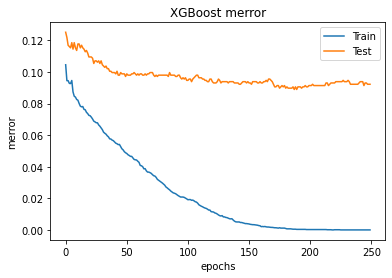

In [185]:
# plot train vs test

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot

clf = XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.8, colsample_bytree=0.8,max_depth=8,
 min_child_weight=1, objective= 'multi:softmax', num_class = 3, n_estimators=250, reg_lambda = 1)

data = [(X_train, y_train), (X_test, y_test)]

clf.fit(X_train, y_train, eval_metric=["merror"], eval_set=data, verbose=True)

y_pred = clf.predict(X_test)
preds = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

results = clf.evals_result()

epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
pyplot.ylabel('merror')
pyplot.xlabel('epochs')
pyplot.title('XGBoost merror')
pyplot.show()

In [ ]:
X_train_drop = X_train.drop(columns=['FALSE POSITIVE'])
X_val_drop = X_val.drop(columns=['FALSE POSITIVE'])

In [ ]:
clf1 = xgb.XGBClassifier(learning_rate =0.1, gamma=0, subsample=0.9, colsample_bytree=0.9,max_depth=8,
 min_child_weight=0, objective= 'multi:softmax', num_class = 3, n_estimators=150, reg_alpha = 0.001).fit(X_train_drop, y_train.values.ravel())


clf1.fit(X_train_drop, y_train)

y_pred_drop = clf1.predict(X_val_drop)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
cm_drop = confusion_matrix(y_val, y_pred_drop)
print(cm_drop)

[[408  95 136]
 [103 502  23]
 [116  41 763]]


In [ ]:
print(classification_report(y_val, y_pred_drop, digits=3))

              precision    recall  f1-score   support

           0      0.651     0.638     0.645       639
           1      0.787     0.799     0.793       628
           2      0.828     0.829     0.828       920

    accuracy                          0.765      2187
   macro avg      0.755     0.756     0.755      2187
weighted avg      0.764     0.765     0.765      2187



Feature: 0, Score: 0.03868
Feature: 1, Score: 0.04067
Feature: 2, Score: 0.09340
Feature: 3, Score: 0.06688
Feature: 4, Score: 0.05802
Feature: 5, Score: 0.16095
Feature: 6, Score: 0.09201
Feature: 7, Score: 0.04662
Feature: 8, Score: 0.04245
Feature: 9, Score: 0.03462
Feature: 10, Score: 0.04859
Feature: 11, Score: 0.03003
Feature: 12, Score: 0.03134
Feature: 13, Score: 0.16242
Feature: 14, Score: 0.05333


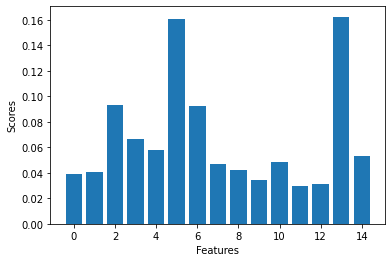

In [ ]:
#plot feature importance without False Positive

from matplotlib import pyplot
importance = clf1.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

pyplot.bar([x for x in range(len(importance))], importance)
pyplot.xlabel('Features')
pyplot.ylabel('Scores')
pyplot.show()

In [ ]:
X_train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8745 entries, 4414 to 1296
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pl_orbper       8745 non-null   float64
 1   pl_orbpererr1   8745 non-null   float64
 2   pl_orbpererr2   8745 non-null   float64
 3   pl_tranmid      8745 non-null   float64
 4   pl_tranmiderr1  8745 non-null   float64
 5   pl_tranmiderr2  8745 non-null   float64
 6   pl_rade         8745 non-null   float64
 7   pl_radeerr1     8745 non-null   float64
 8   pl_radeerr2     8745 non-null   float64
 9   st_rad          8745 non-null   float64
 10  st_raderr1      8745 non-null   float64
 11  st_raderr2      8745 non-null   float64
 12  kep_mag         8745 non-null   float64
 13  CONFIRMED       8745 non-null   uint8  
 14  obj             8745 non-null   int64  
dtypes: float64(13), int64(1), uint8(1)
memory usage: 1.0 MB


In [ ]:
final_train.corr()

,disp,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,st_rad,st_raderr1,st_raderr2,kep_mag,CONFIRMED,FALSE POSITIVE,obj
disp,1.000000,-0.019486,-0.014809,0.014765,-0.268654,0.016652,-0.016520,0.015243,0.011446,-0.014023,0.043963,0.075005,-0.043685,0.033166,-0.026716,0.892792,-0.154824
pl_orbper,-0.019486,1.000000,0.541196,-0.541204,-0.001519,0.025303,-0.025318,0.004308,0.002827,-0.004145,-0.001241,-0.000903,0.001625,-0.020610,-0.006634,-0.006964,-0.007914
pl_orbpererr1,-0.014809,0.541196,1.000000,-0.999984,0.026636,-0.003687,0.003703,-0.000293,-0.000431,0.000268,-0.001602,-0.003190,0.001440,-0.033283,-0.001681,-0.009503,-0.003736
pl_orbpererr2,0.014765,-0.541204,-0.999984,1.000000,-0.026453,0.003648,-0.003661,0.000290,0.000428,-0.000266,0.001592,0.003173,-0.001432,0.033238,0.001669,0.009486,0.003732
pl_tranmid,-0.268654,-0.001519,0.026636,-0.026453,1.000000,-0.078702,0.079267,-0.011139,-0.012904,0.008912,-0.033326,-0.069531,0.031813,-0.282911,0.381335,-0.293679,-0.021531
pl_tranmiderr1,0.016652,0.025303,-0.003687,0.003648,-0.078702,1.000000,-0.999759,0.020071,0.016912,-0.018817,0.017337,0.053227,-0.020820,-0.030053,0.003952,0.089125,-0.017536
pl_tranmiderr2,-0.016520,-0.025318,0.003703,-0.003661,0.079267,-0.999759,1.000000,-0.020083,-0.016929,0.018829,-0.017399,-0.053494,0.020933,0.029907,-0.003912,-0.089160,0.017549
pl_rade,0.015243,0.004308,-0.000293,0.000290,-0.011139,0.020071,-0.020083,1.000000,0.722168,-0.987640,0.053534,0.035413,-0.053168,-0.016026,-0.004695,0.021119,-0.008507
pl_radeerr1,0.011446,0.002827,-0.000431,0.000428,-0.012904,0.016912,-0.016929,0.722168,1.000000,-0.660121,0.044390,0.061528,-0.042495,-0.009016,-0.006531,0.021187,-0.009007
pl_radeerr2,-0.014023,-0.004145,0.000268,-0.000266,0.008912,-0.018817,0.018829,-0.987640,-0.660121,1.000000,-0.049361,-0.031037,0.053445,0.016792,0.003973,-0.018822,0.007481


RANDOM FOREST

In [150]:
from sklearn.ensemble import RandomForestClassifier

In [151]:
clf = RandomForestClassifier().fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [152]:
 cv = cross_val_score(clf, X_train, y_train, cv = 10, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

In [153]:
cv

array([0.90057143, 0.89142857, 0.92114286, 0.90057143, 0.89257143,
       0.89130435, 0.8993135 , 0.89816934, 0.89359268, 0.89816934])

In [154]:
y_pred = clf.predict(X_val)

In [155]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [156]:
print(confusion_matrix(y_val, y_pred))

[[576 115   0]
 [113 458   4]
 [  1   3 917]]


In [157]:
print(classification_report(y_val, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.835     0.834     0.834       691
           1      0.795     0.797     0.796       575
           2      0.996     0.996     0.996       921

    accuracy                          0.892      2187
   macro avg      0.875     0.875     0.875      2187
weighted avg      0.892     0.892     0.892      2187



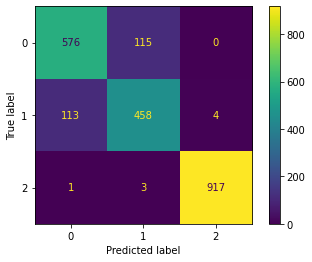

In [158]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_val, y_val, values_format = '')